<a href="https://colab.research.google.com/github/minimixx112/practice-efficientnet/blob/main/CNN_model_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms



In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#데이터 불러오기, 학습여부  o
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

#학습용 셋은 섞어서 뽑기
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
#데이터 불러오기, 학습여부  x
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
#테스트 셋은 굳이 섞을 필요가 없음
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)
#클래스들
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 57924920.85it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


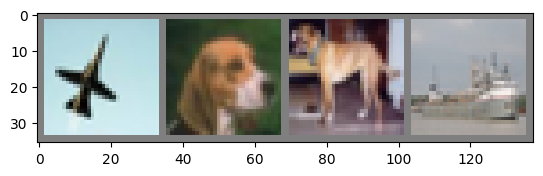

plane   dog   dog  ship


In [5]:
import matplotlib.pyplot as plt
import numpy as np

#이미지 확인하기

def imshow(img):
    img = img / 2 + 0.5     # 정규화 해제
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지 뽑기
dataiter = iter(trainloader)
images, labels = next(iter(trainloader))

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))

# 이미지별 라벨 (클래스) 보여주기
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        #input = 3, output = 6, kernal = 5
        self.conv1 = nn.Conv2d(3, 6, 5)
        #kernal = 2, stride = 2, padding = 0 (default)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        #input feature, output feature
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    # 값 계산
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# GPU 사용 가능 여부 확인
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 모델을 GPU로 이동
net = Net().to(device)

Using device: cpu


In [7]:
import torch.optim as optim

# 모델을 GPU로 이동
net.to(device)

# 손실 함수 정의
criterion = nn.CrossEntropyLoss()

# SGD 옵티마이저 정의
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# 옵티마이저의 파라미터를 GPU로 이동
for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)

In [9]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

# Training loop
train_losses = []  # running_loss 저장
val_losses = []    # val_loss 저장
accuracies = []    # accuracy 저장

for epoch in range(10):
    running_loss = 0.0
    net.train()  # 학습 모드로 변경
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    # 매 에폭마다 검증 데이터셋을 사용하여 모델 성능 평가
    net.eval()  # 평가 모드로 변경
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # 에폭별로 정보 저장
    train_losses.append(running_loss / len(trainloader))
    val_losses.append(val_loss / len(testloader))
    accuracies.append(100 * correct / total)

    print(f'Epoch {epoch + 1}, Validation Loss: {val_loss / len(testloader)}, Accuracy: {100 * correct / total}%')

# 학습한 모델 저장
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

[1,  2000] loss: 0.523
[1,  4000] loss: 0.586
[1,  6000] loss: 0.601
[1,  8000] loss: 0.613
[1, 10000] loss: 0.644
[1, 12000] loss: 0.665
Epoch 1, Validation Loss: 1.63569731786733, Accuracy: 59.43%
[2,  2000] loss: 0.510
[2,  4000] loss: 0.567
[2,  6000] loss: 0.620
[2,  8000] loss: 0.607
[2, 10000] loss: 0.622
[2, 12000] loss: 0.650
Epoch 2, Validation Loss: 1.7268233791258034, Accuracy: 58.42%
[3,  2000] loss: 0.515
[3,  4000] loss: 0.565
[3,  6000] loss: 0.602
[3,  8000] loss: 0.602
[3, 10000] loss: 0.683
[3, 12000] loss: 0.658
Epoch 3, Validation Loss: 1.7780693173582687, Accuracy: 59.25%
[4,  2000] loss: 0.534
[4,  4000] loss: 0.543
[4,  6000] loss: 0.609
[4,  8000] loss: 0.590
[4, 10000] loss: 0.664
[4, 12000] loss: 0.630
Epoch 4, Validation Loss: 1.7866749376807216, Accuracy: 57.24%
[5,  2000] loss: 0.517
[5,  4000] loss: 0.579
[5,  6000] loss: 0.601
[5,  8000] loss: 0.612
[5, 10000] loss: 0.631
[5, 12000] loss: 0.599
Epoch 5, Validation Loss: 1.8087817177747143, Accuracy: 58.4

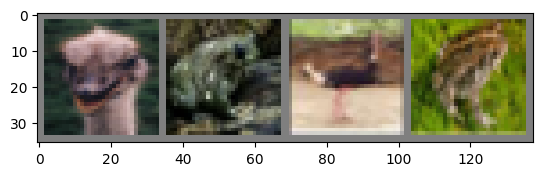

GroundTruth:   bird  frog  bird  frog
Predicted:    cat  frog  bird  frog


In [10]:
dataiter = iter(testloader)
images, labels = next(iter(trainloader))

# 실험용 데이터와 결과 출력
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

# 학습한 모델로 예측값 뽑아보기
net = Net()
net.load_state_dict(torch.load(PATH))
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [11]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 58 %


In [12]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, prediceted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuract of %5s : %2d %%' %(
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuract of plane :  0 %
Accuract of   car :  0 %
Accuract of  bird :  0 %
Accuract of   cat : 24 %
Accuract of  deer : 25 %
Accuract of   dog : 25 %
Accuract of  frog :  0 %
Accuract of horse : 25 %
Accuract of  ship :  0 %
Accuract of truck :  0 %


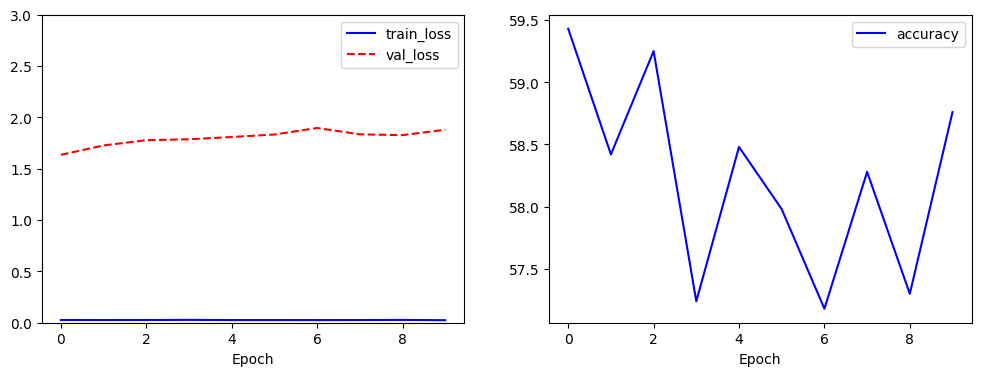

In [13]:
# 그래프 그리기
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', label='train_loss')
plt.plot(val_losses, 'r--', label='val_loss')
plt.ylim(0, 3)
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies, 'b-', label='accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()